In [3]:
import math
import time
import ccxt
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba 
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
import requests
from datetime import datetime

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

In [23]:
time.time()

1647774220.2611048

In [5]:
#改良版(ループ処理も関数の中に入れてしまったので、直感的に1000件とかのデータを好きな分足で取得できます。コインも変数にしました。)
def fetch_ohlcv_v2(symbol="BTCUSDT", limit=1000, interval=1):

    # 関数の中で関数を定義
    def fetch_ohlcv(symbol=symbol, l=200, interval=interval, k=1):
        base_url = "https://api-testnet.bybit.com/public/linear/kline"
        params = {
            "symbol": symbol,  
            "interval": interval,  
            "limit": l, # 取得件数(The number of data points to return)
            "from" : int(time.time() - interval*l*60*k) #今より昔のものをとる　#分・個数=秒
        }
    
        res = requests.get(base_url, params, timeout = 10).json()
        Time, Open, High, Low, Close, Volume = [],[],[],[],[],[]
        for i in res['result']:
            Time.append(datetime.fromtimestamp(i["open_time"]))
            Open.append(i["open"])
            High.append(i["high"])
            Low.append(i["low"])
            Close.append(i["close"])
            Volume.append(i["volume"]) # volumefrom (BTCの単位) vlumeto(USDTの単位)
    
        candles = pd.DataFrame({
            "time": Time,  # 時刻
            "open": Open,  # 始値
            "high": High,  # 高音
            "low": Low,    # 安値
            "close": Close, # 終値
            "volume": Volume #出来高
        })

        return(candles)
    

    df = fetch_ohlcv(interval=interval, l=200, k=1)
    iter = int(limit/200) - 1
    for i in range(iter):
        df2 = fetch_ohlcv(interval=interval, l=200, k=i+1)
        df = pd.concat([df2,df],ignore_index=True)
    
    return(df)

In [6]:
df = fetch_ohlcv_v2(symbol="BTCUSDT", limit=10000 ,interval=5)

In [7]:
df
#df.info()

,time,open,high,low,close,volume
0,2022-02-20 12:15:00,39877.5,39895.0,39875.0,39889.0,6.127
1,2022-02-20 12:20:00,39889.0,39889.0,39845.5,39845.5,4.950
2,2022-02-20 12:25:00,39845.5,39846.0,39753.0,39804.5,42.608
3,2022-02-20 12:30:00,39804.5,39853.5,39739.5,39753.5,26.194
4,2022-02-20 12:35:00,39753.5,39849.0,39753.0,39846.5,14.896
...,...,...,...,...,...,...
9995,2022-03-26 12:30:00,44393.0,44393.5,44365.0,44370.0,1.852
9996,2022-03-26 12:35:00,44370.0,44370.5,44313.5,44332.5,10.906
9997,2022-03-26 12:40:00,44332.5,44366.5,44332.5,44366.5,7.036
9998,2022-03-26 12:45:00,44366.5,44388.0,44366.5,44374.5,32.379


<AxesSubplot:>

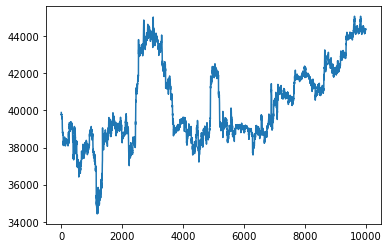

In [8]:
df['close'].plot()

In [9]:
df['white'] = (df['close'] - df['open'])
df['black'] = (df['open'] - df['close'])
df['white_down_hige'] = df['open'] - df['low'] #陽線での下ヒゲ
df['white_up_hige'] = df['high'] - df['close']
df['black_down_hige'] = df['close'] - df['low'] #陰線での下ヒゲ
df['black_up_hige'] = df['high'] - df['open']

In [10]:
df

,time,open,high,low,close,volume,white,black,white_down_hige,white_up_hige,black_down_hige,black_up_hige
0,2022-02-20 12:15:00,39877.5,39895.0,39875.0,39889.0,6.127,11.5,-11.5,2.5,6.0,14.0,17.5
1,2022-02-20 12:20:00,39889.0,39889.0,39845.5,39845.5,4.950,-43.5,43.5,43.5,43.5,0.0,0.0
2,2022-02-20 12:25:00,39845.5,39846.0,39753.0,39804.5,42.608,-41.0,41.0,92.5,41.5,51.5,0.5
3,2022-02-20 12:30:00,39804.5,39853.5,39739.5,39753.5,26.194,-51.0,51.0,65.0,100.0,14.0,49.0
4,2022-02-20 12:35:00,39753.5,39849.0,39753.0,39846.5,14.896,93.0,-93.0,0.5,2.5,93.5,95.5
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2022-03-26 12:30:00,44393.0,44393.5,44365.0,44370.0,1.852,-23.0,23.0,28.0,23.5,5.0,0.5
9996,2022-03-26 12:35:00,44370.0,44370.5,44313.5,44332.5,10.906,-37.5,37.5,56.5,38.0,19.0,0.5
9997,2022-03-26 12:40:00,44332.5,44366.5,44332.5,44366.5,7.036,34.0,-34.0,0.0,0.0,34.0,34.0
9998,2022-03-26 12:45:00,44366.5,44388.0,44366.5,44374.5,32.379,8.0,-8.0,0.0,13.5,8.0,21.5


In [11]:
df_white = df.query('white > 0')

In [12]:
df_black = df.query('black > 0')

In [13]:
df_white

,time,open,high,low,close,volume,white,black,white_down_hige,white_up_hige,black_down_hige,black_up_hige
0,2022-02-20 12:15:00,39877.5,39895.0,39875.0,39889.0,6.127,11.5,-11.5,2.5,6.0,14.0,17.5
4,2022-02-20 12:35:00,39753.5,39849.0,39753.0,39846.5,14.896,93.0,-93.0,0.5,2.5,93.5,95.5
6,2022-02-20 12:45:00,39771.0,39814.0,39771.0,39810.5,5.166,39.5,-39.5,0.0,3.5,39.5,43.0
8,2022-02-20 12:55:00,39753.0,39820.5,39752.5,39805.0,13.068,52.0,-52.0,0.5,15.5,52.5,67.5
11,2022-02-20 13:10:00,39760.5,39786.0,39754.0,39767.5,246.955,7.0,-7.0,6.5,18.5,13.5,25.5
...,...,...,...,...,...,...,...,...,...,...,...,...
9992,2022-03-26 12:15:00,44336.0,44361.5,44336.0,44361.5,14.973,25.5,-25.5,0.0,0.0,25.5,25.5
9993,2022-03-26 12:20:00,44361.5,44398.5,44361.5,44398.5,11.844,37.0,-37.0,0.0,0.0,37.0,37.0
9997,2022-03-26 12:40:00,44332.5,44366.5,44332.5,44366.5,7.036,34.0,-34.0,0.0,0.0,34.0,34.0
9998,2022-03-26 12:45:00,44366.5,44388.0,44366.5,44374.5,32.379,8.0,-8.0,0.0,13.5,8.0,21.5


In [14]:
df_black

,time,open,high,low,close,volume,white,black,white_down_hige,white_up_hige,black_down_hige,black_up_hige
1,2022-02-20 12:20:00,39889.0,39889.0,39845.5,39845.5,4.950,-43.5,43.5,43.5,43.5,0.0,0.0
2,2022-02-20 12:25:00,39845.5,39846.0,39753.0,39804.5,42.608,-41.0,41.0,92.5,41.5,51.5,0.5
3,2022-02-20 12:30:00,39804.5,39853.5,39739.5,39753.5,26.194,-51.0,51.0,65.0,100.0,14.0,49.0
5,2022-02-20 12:40:00,39846.5,39848.0,39732.0,39771.0,5.621,-75.5,75.5,114.5,77.0,39.0,1.5
7,2022-02-20 12:50:00,39810.5,39810.5,39753.0,39753.0,18.399,-57.5,57.5,57.5,57.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9987,2022-03-26 11:50:00,44291.0,44291.5,44200.0,44243.0,13.772,-48.0,48.0,91.0,48.5,43.0,0.5
9990,2022-03-26 12:05:00,44338.0,44341.0,44331.5,44332.5,12.734,-5.5,5.5,6.5,8.5,1.0,3.0
9994,2022-03-26 12:25:00,44398.5,44401.0,44393.0,44393.0,4.633,-5.5,5.5,5.5,8.0,0.0,2.5
9995,2022-03-26 12:30:00,44393.0,44393.5,44365.0,44370.0,1.852,-23.0,23.0,28.0,23.5,5.0,0.5


17.04596322941647
29.235588824223996


time               572
open               572
high               572
low                572
close              572
volume             572
white              572
black              572
white_down_hige    572
white_up_hige      572
black_down_hige    572
black_up_hige      572
dtype: int64

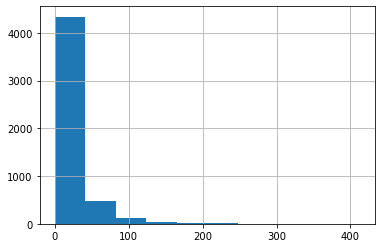

In [33]:
df_white['white_down_hige'].hist()
print(df_white['white_down_hige'].mean())
print(df_white['white_down_hige'].std())
df_white.query('40 < white_down_hige < 100').count()

48.4505
64.8161500945664


time               754
open               754
high               754
low                754
close              754
volume             754
white              754
black              754
white_down_hige    754
white_up_hige      754
black_down_hige    754
black_up_hige      754
dtype: int64

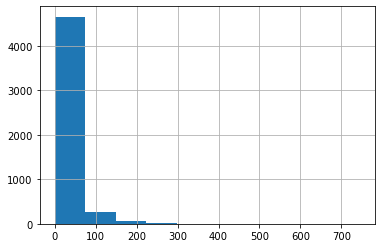

In [34]:
df_white['white_up_hige'].hist()
print(df['white_up_hige'].mean())
print(df['white_up_hige'].std())
df_white.query('40 < white_up_hige < 100').count()

21.05500505561173

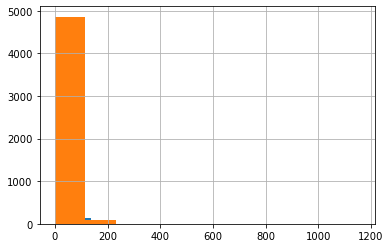

In [20]:
df_black['black_down_hige'].hist()
df_black['black_up_hige'].hist()
df_black['black_down_hige'].mean()

In [21]:
df_black['black_up_hige'].mean()

17.458645096056625

In [66]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set3')


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False, ax=ax)
sns.stripplot(x='variable', y='value', data=df_melt, jitter=True, color='black', ax=ax)

plt.show()

<AxesSubplot:>

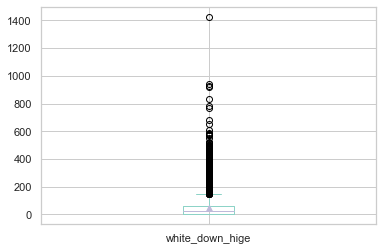

In [72]:
df['white_down_hige'].plot.box(showmeans=True)

<AxesSubplot:>

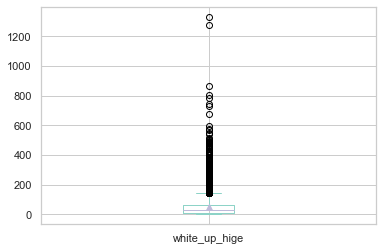

In [71]:
df['white_up_hige'].plot.box(showmeans=True)